# Demand Forecast

The **goal** of this exercise is to create a demand forecast model for different products (or clusters of products).

The **evaluation** of the assignment will follow:

* Design process and thinking as a data analyst.
* Validation of knowledge on the different tools and steps throughout the process.
* Storytelling and visualisation of the insights.


Exercise **workflow**:

* Import dependencies & data (`../data/Historical\ Product\ Demand.csv`).
* Explore the dataset to assess its quality (nulls, skew, data types).
* Explore the dataset to obtain insights related to the production (e.g., unvariate / bivariate analysis).
* Explore the dataset as a time-series (min/max dates, seasonality, trends etc.).
* Implement / apply a forecast model:
    * Theory
    * Parameters tuning
    * Build/fit & Validation
    * Evaluate performance (e.g., forecast accuracy)
    
Notes:

Feel free to choose how to present the results throughout the exercise, what libraries (e.g., seaborn, bokeh, etc.) and tools (e.g., PowerBI or Tableau).
    

In [33]:
### ------------------------------------------->  REPLACE PATH ACCORDINGLY <--------------------------------------------------
!pip install -r ../requirements.txt

Defaulting to user installation because normal site-packages is not writeable


## Preamble

In [34]:
import pandas as pd
import numpy as np
import seaborn as sb

import missingno as msno
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')
import seaborn as sns


import matplotlib.pyplot as plt
%matplotlib inline

# not mandatory, but might come handy
from scipy import stats
import statsmodels.api as sm

PLOT_SIZE_IN_INCHES = 20, 20



### ------------------------------------------->  REPLACE PATH ACCORDINGLY <--------------------------------------------------
%run ./functions.ipynb


In [35]:
### REPLACE WITH YOUR PATH
BASE_PATH = '../data'

df = build_df_from_csv('Historical Product Demand.csv', BASE_PATH = BASE_PATH, clean_headers = False) 
df.head(3)

Reading: Historical Product Demand.csv
shape: (1048575, 5)
columns: ['Product_Code', 'Warehouse', 'Product_Category', 'Date', 'Order_Demand']
pc_number_of_null_values: 0.002144



,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500


## Data exploration

### Data quality assessment

* Explore the dataset to assess its quality (nulls, skew, data types)



<AxesSubplot:>

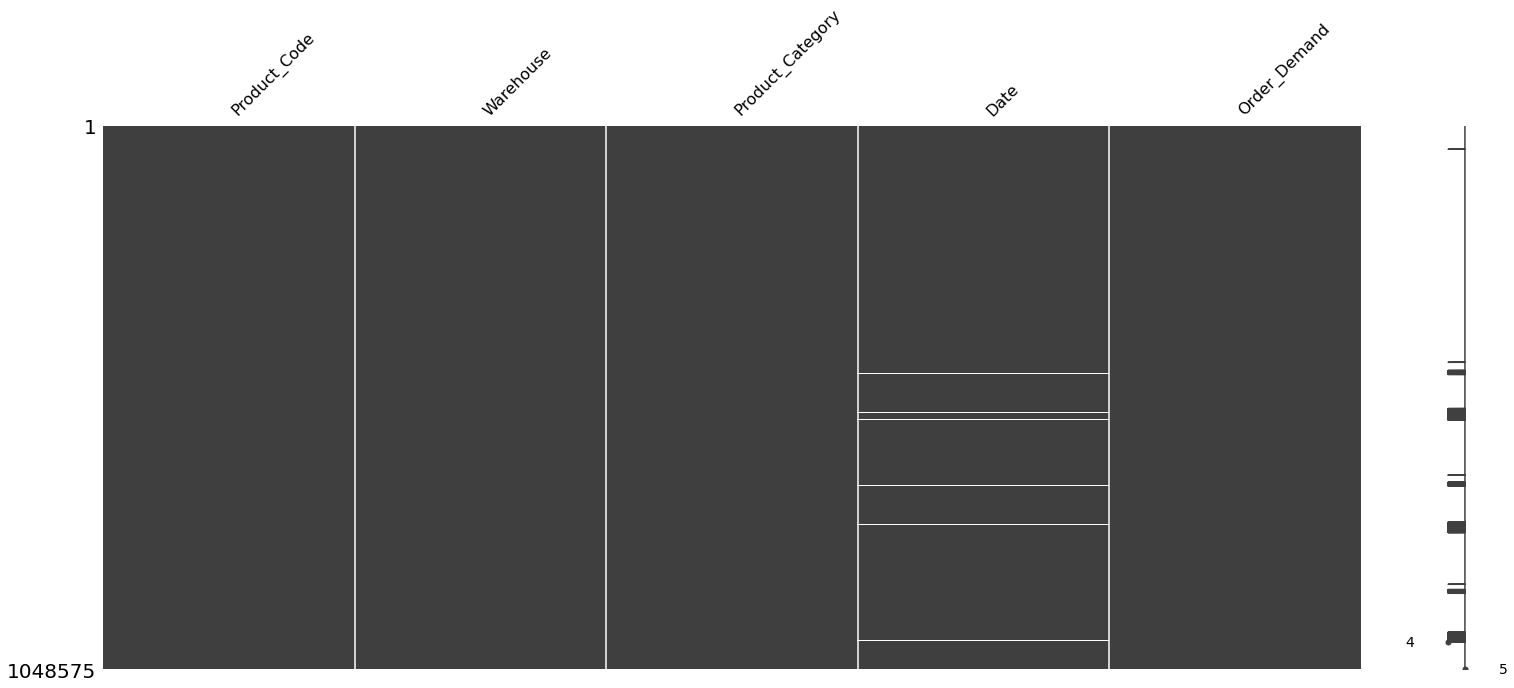

In [36]:
#Observe that there a few nulls in the data col. 
#These can probably be filled by looking previous and next row
msno.matrix(df)

In [37]:
# Order_Demand should probably be a numeric col, not string
df.dtypes

Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand        object
dtype: object

In [38]:
# In order to plot the dist, I need first to clean Order_Demand and "Date"

df['Order_Demand']=df['Order_Demand'].astype(str).str.replace('(', '').str.replace(')', '')
df['Order_Demand']=df['Order_Demand'].astype(float)

df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

<AxesSubplot:xlabel='Order_Demand', ylabel='Density'>

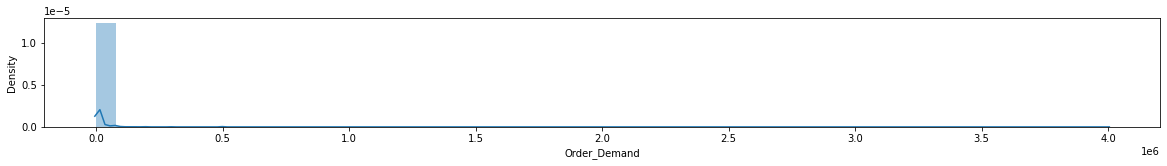

In [39]:
# Highly skew data (L-shape)
fig, ax=plt.subplots(1,1)

# This plot I make smaller than the other ones, to see more clearly the witdh.
fig.set_size_inches(20, 2)
sns.distplot(df['Order_Demand'], ax=ax)

<AxesSubplot:xlabel='Date'>

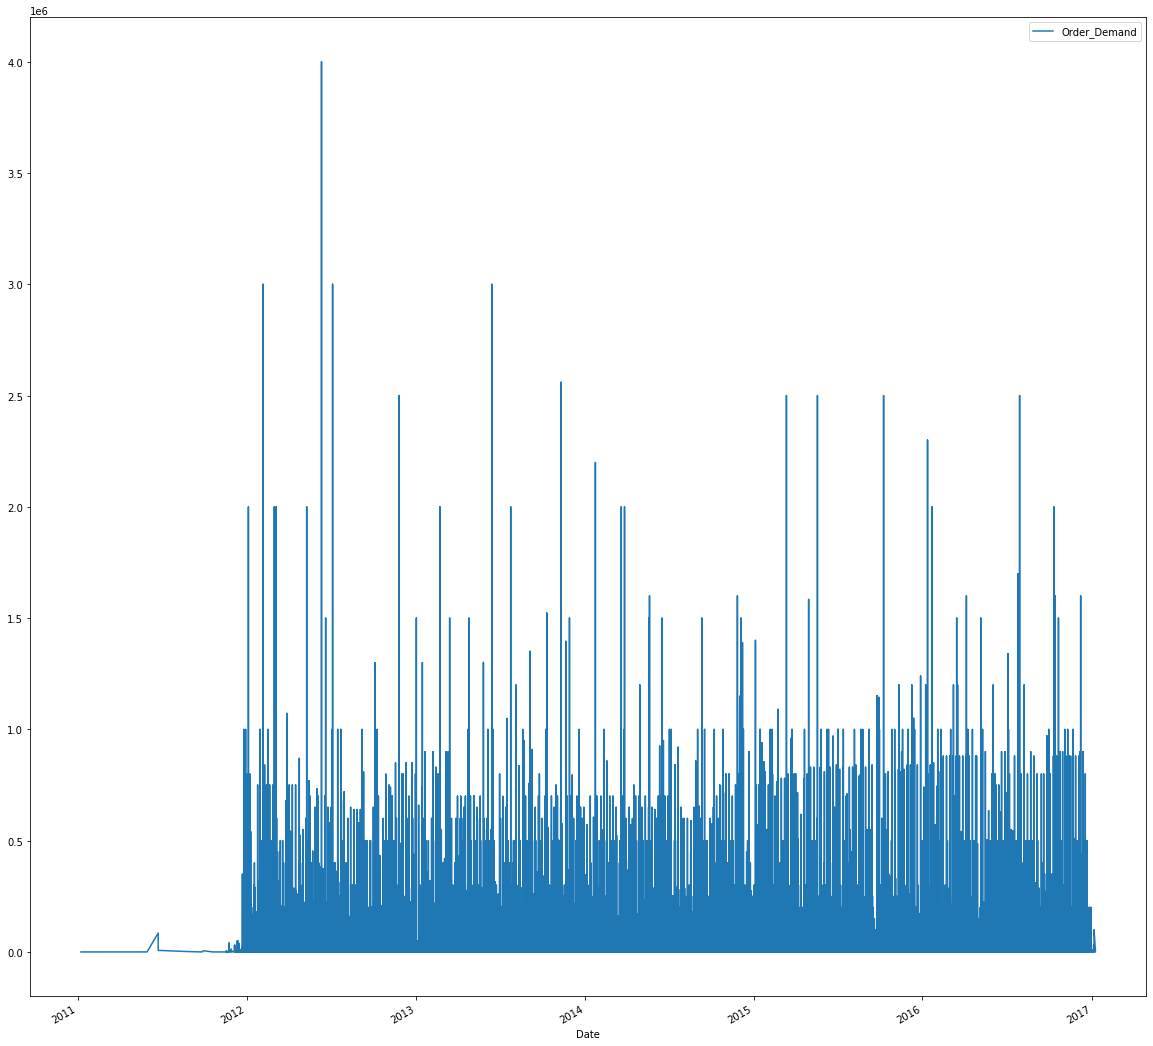

In [40]:
# Here we see that there's something wrong with order_demand before 2012.
# Same after 2017.

df[['Date', 'Order_Demand']].set_index('Date').plot(kind='line',figsize=PLOT_SIZE_IN_INCHES)

<AxesSubplot:xlabel='Date'>

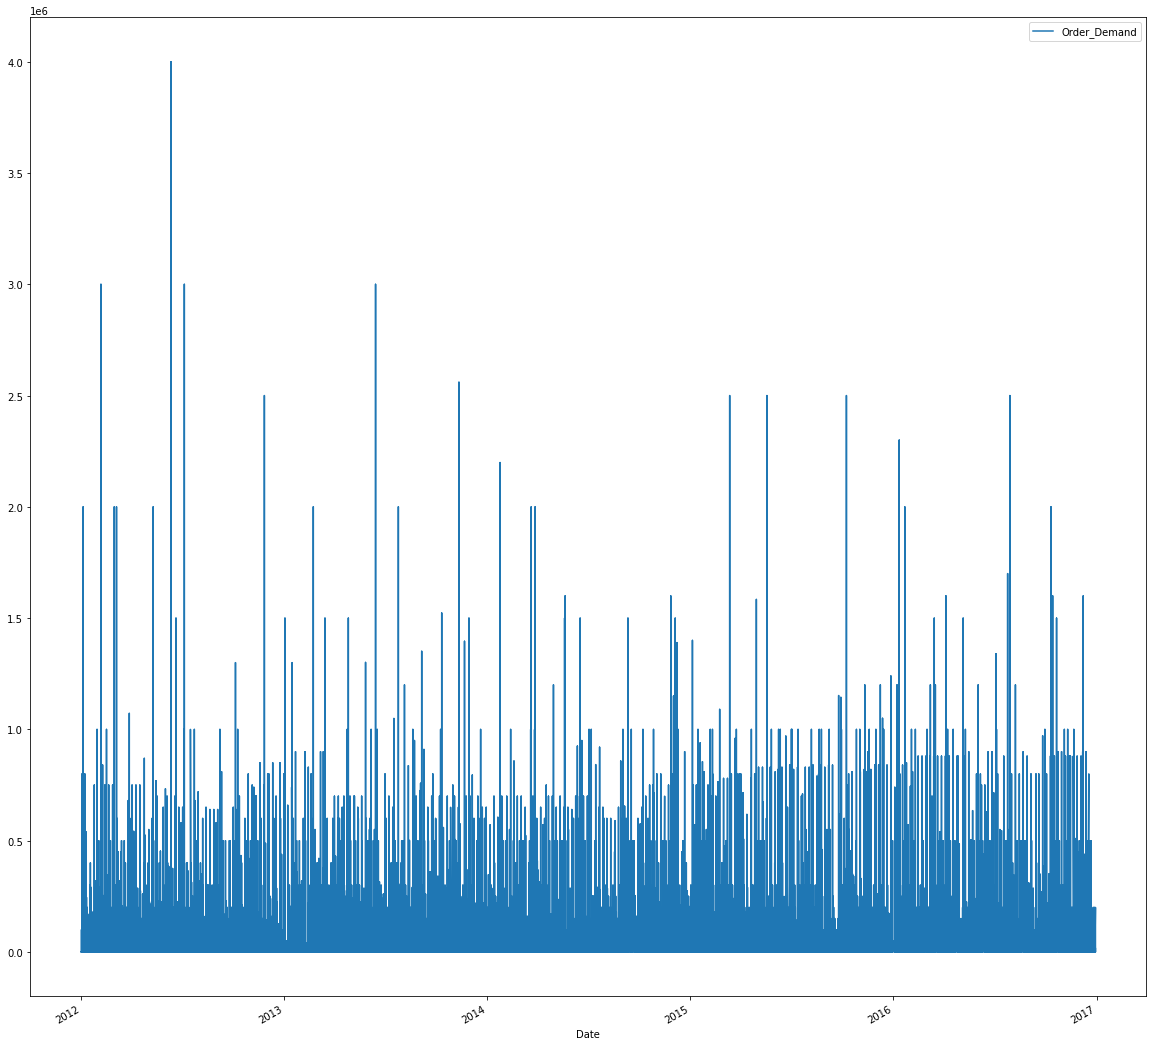

In [41]:
# I try only keeping the values between 2012-2017, and re-plot

df = df[(df['Date']>='2012-01-01') & (df['Date']<='2016-12-31')] 
df[['Date', 'Order_Demand']].set_index('Date').plot(kind='line',figsize=PLOT_SIZE_IN_INCHES)

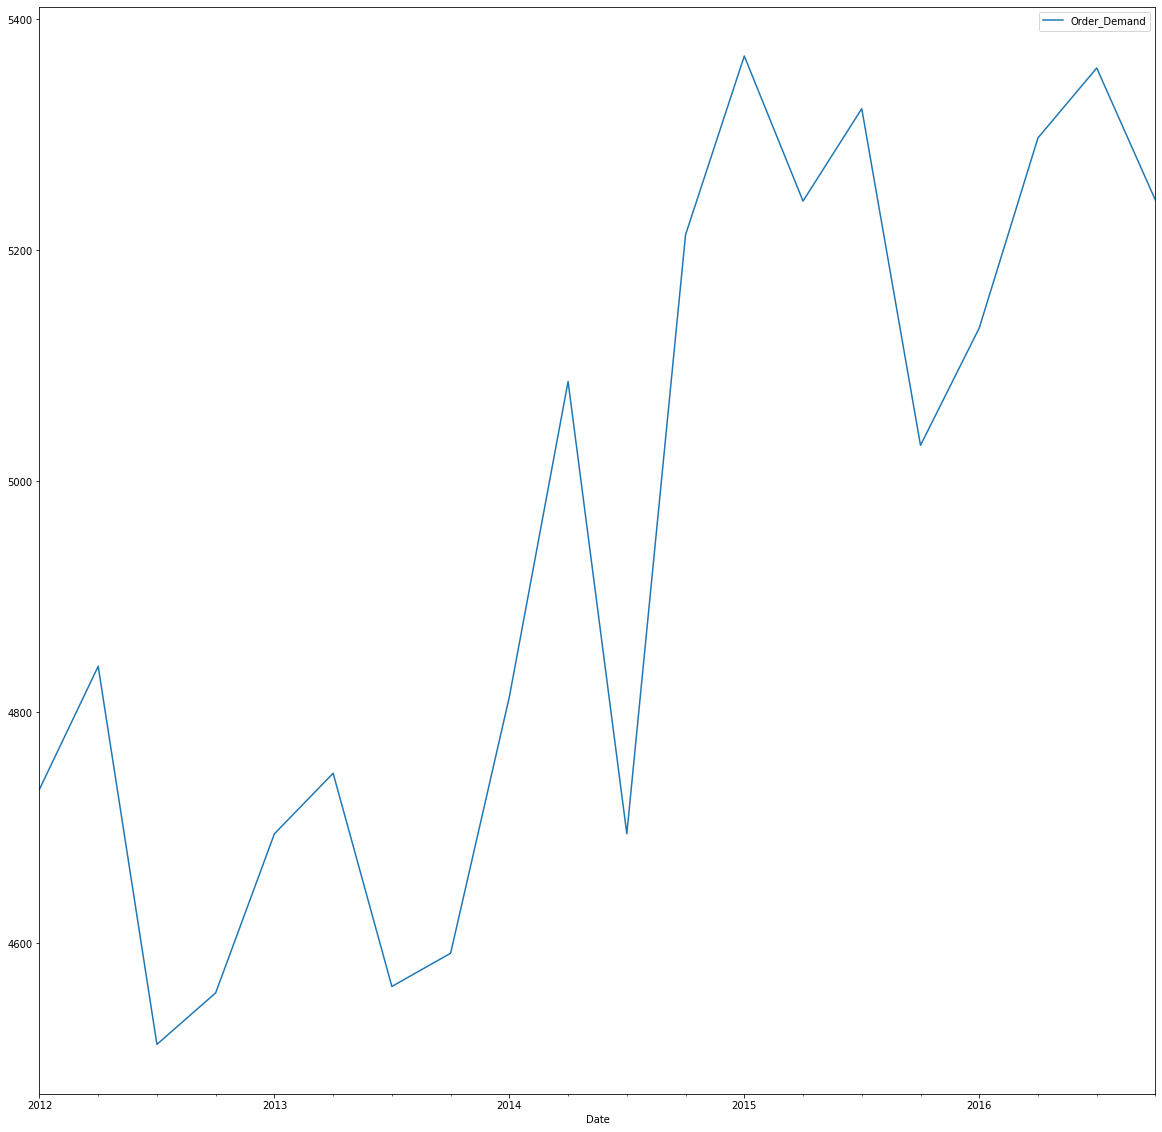

In [42]:
# The plots above contain a lof of short-term noise, which make trends difficult to see for the naked eye. 
# In other words, I dont care about the daily ups and downs, which stem from random variability.
# It is more interesting to see the average demand per quarter, when looking over many years. 

# For this, I smooth down the graph by resampling using month end frequency (Q means "quarter end frequency")
# Check "offset aliases" for reference: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html 

# Now, we see a clear upwards tendency in demand, when looking at the evolution quarter by quarter. 

s_order_demand_resampled =  df[['Date','Order_Demand']].set_index('Date').resample('Q').mean()
print('')
s_order_demand_resampled.plot(figsize=PLOT_SIZE_IN_INCHES)
plt.show()

### Production insights
* What products / categories are driving the demand?



In [43]:
# Category_019 drives the demand. Inside this category, the top product is 1359
df.groupby(['Product_Category', 'Product_Code']).sum().sort_values('Order_Demand', ascending=False)   

Order_Demand
Product_Category Product_Code              
Category_019     Product_1359   472374000.0
                 Product_1248   289117000.0
                 Product_0083   210651000.0
                 Product_1341   166411000.0
                 Product_1295   123303000.0
...                                     ...
Category_007     Product_0638          22.0
Category_021     Product_0853          20.0
Category_012     Product_0465           3.0
Category_021     Product_1703           2.0
                 Product_1698           2.0

[2160 rows x 1 columns]

* What warehouses are driving the production?

In [44]:
# Assumption: production matches demand perfectly at all times. So we can infer production by looking at demand. 
# Warehouse J leads the production
df.groupby('Warehouse').sum().sort_values('Order_Demand', ascending=False)   #[['Order_Demand']].sum().sort_values(['Order_Demand'], ascending=False)

,Order_Demand
Warehouse,
Whse_J,3.362743e+09
Whse_S,1.033122e+09
Whse_C,5.820042e+08
Whse_A,1.476466e+08


### Time-series insights
* Are there missing dates?


In [45]:
# Yes, as shown when I plotted the nulls matrix

* Are all dates valid?


* What is the seasonability decomposition?

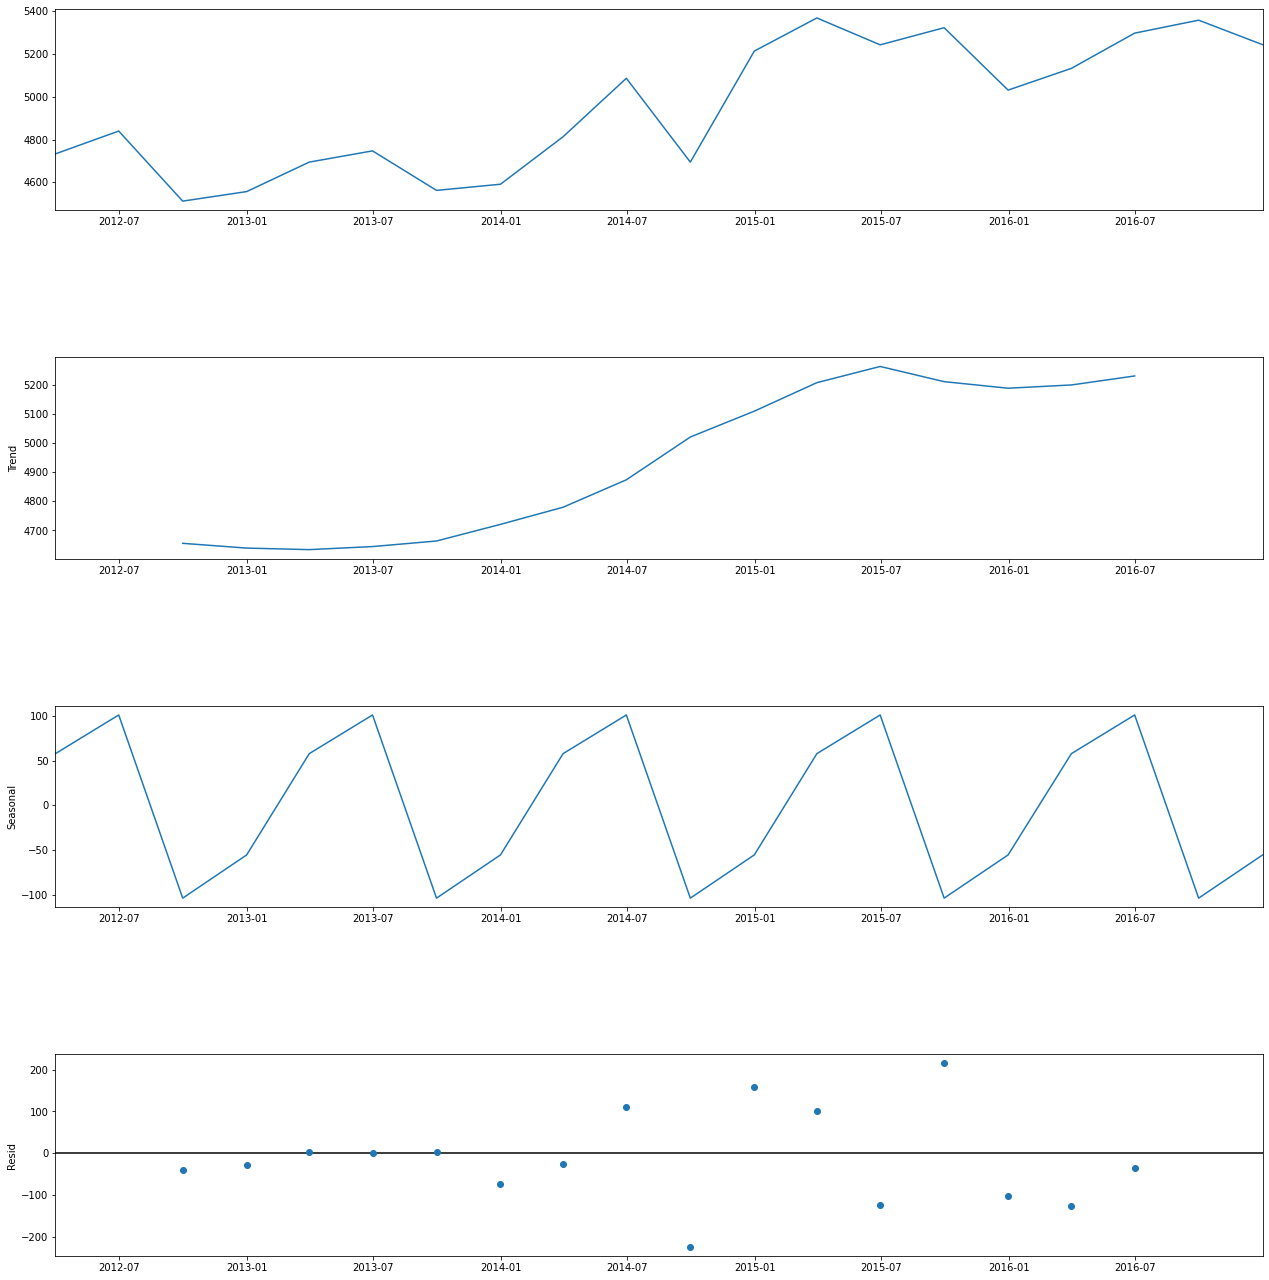

In [46]:
### ---- THEORY ----
# The Seasonal Decomposition procedure decomposes a series into a seasonal component, a combined trend and cycle component, and an "error" component. 
# Source: https://www.ibm.com/support/knowledgecenter/SSLVMB_sub/statistics_mainhelp_ddita/spss/trends/idh_seas.html 

# The idea is that any point can be decomposed into three components: trend, season, and error (noise)
# y = trend + season + e 

# "e" is assumed to be normally distributed, because its just noise, it shouldnt be produced by any identifiable source or factor. 


# A generic, easy to grasp example:
# year 1: demand_summer = 3 , demand_winter = 3
# year 2: demand_summer = 12, demand_winter = 12 

# Even though the year-by-year increase was 4 times, this is increase is 100% indepdent of the season (consumers do not care if its summer or winter).  
# In other words, trend and season are by definition orthogonal. 


### ---- IN THIS PROBLEM ----
# The seasonability decomposition confirm our insights from above:
# First and second graph: the demand year by year (or semester-by-semester) is increasing
# Third graph: It also looks like the increments are independt of the season.

# Fourth graph: Just shows the random variation, or noise, from the expected value (expected or predicted by the algorithm). 
# If the points were not in this graph were not randomely distributed around 0, then the model is broken; it makes no sense to decompose the data with this procedure.  


# I didnt have time to do more 

decomposition = seasonal_decompose(s_order_demand_resampled, model='additive')
fig = decomposition.plot()
fig.set_size_inches(PLOT_SIZE_IN_INCHES)
plt.show()

## Forecast model

### Theory
* Describe the basic theory behind the solution you have decided to apply

### Implementation
* What parameters have you consider to tune and why are those important for best-fit?